In [1]:
import numba
from numba import jit, njit, vectorize, prange
import cvxpy as cp
import numpy as np
import pandas as pd
import scipy.stats as scs
from numpy.linalg import cholesky
import math
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [12]:
demand_file = pd.read_excel("D:\\University\\Masters\\Thesis\\Data\\Load_duration.xlsx")
demand = demand_file["Demand"].to_numpy()
T,M,I = 25,25,100
rho = np.array([[1, 0.66],
                [0.66, 1]])
lower_chol = np.linalg.cholesky(rho)
Z = np.random.normal(0.0, 1.0, size=(M+1, I, 2))
Y = Z @ lower_chol
load = np.repeat(demand, I).reshape((-1,I))
MU = np.array([0, 0])
COV = np.matrix([[1, 0.66], [0.66, 1]])
W = scs.multivariate_normal.rvs( mean=MU, cov=COV, size=(I, M+1) )
W_g = W[:,:,0]   
W_c = W[:,:,1]

In [4]:
def price():
    X0_g, X0_c, X0_n = 2.57, 1.78, 0.62
    load = demand
    el_price = np.zeros(8760)
    cf = np.zeros(8760)
    for t in range(len(load)):
        all_plants = np.array([[14, 0], [4.97, 10], [12.4, (X0_c * 9.99 + 6.55)], [6.87, (X0_c * 10.65 + 6.55)], 
                                            [36.43, (X0_g * 8.36 + 5)], [13.62, (X0_g * 12.09 + 8)], [7.14, (X0_g * 15.13 + 8)]])
        plant = all_plants[np.argsort(all_plants[:, 1])]
        plant_iterator = 1
        while plant[0][0] <= load[t]:
            plant[0][0] += plant[plant_iterator][0]
            el_price[t] = plant[plant_iterator][1] 
            plant_iterator += 1
    return np.mean(el_price), el_price
price()


(26.216827214611875,
 array([24.3322, 24.3322, 24.3322, ..., 26.4852, 26.4852, 26.4852]))

In [13]:
@jit(nopython=True)
def Prices(T, M, I, W):
    dt = T/M
    kappa_g, theta_g, sigma_g, kappa_c, theta_c, sigma_c = 2.86, 4, 1.45, 0.44, 1.63, 0.28
    X_g, X_c = np.zeros((M+1, I)), np.zeros((M+1, I))
    X0_g, X0_c = 2.57, 1.78
    X_g[0], X_c[0] = X0_g, X0_c
    H_c, H_gcc, H_gct = 8.64, 6.43, 9.91
    Q_w, Q_c, Q_gcc, Q_gct = 90, 650, 418, 237
    VC_w, VC_c, VC_gcc, VC_ct = 0, 4.5, 2.67, 4.5
    std_dt_g = np.sqrt(sigma_g ** 2 / (2 * kappa_g) * (1 - np.exp(-2 * kappa_g * dt)))
    std_dt_c = np.sqrt(sigma_c ** 2 / (2 * kappa_c) * (1 - np.exp(-2 * kappa_c * dt)))
    margin_w, margin_c, margin_g, margin_ct = np.zeros((M+1, I)), np.zeros((M+1, I)), np.zeros((M+1, I)), np.zeros((M+1, I))
    for t in range(1, M+1):
        X_g[t] = theta_g + np.exp(-kappa_g * dt) * (X_g[t-1] - theta_g) + std_dt_g * W_g[:,t]
        X_c[t] = theta_c + np.exp(-kappa_c * dt) * (X_c[t-1] - theta_c) + std_dt_c * W_c[:,t]
        load = np.repeat(demand, I).reshape((-1,I))
        MC1 = np.repeat(X_c[t], 8760).reshape((-1,8760)).T
        MC2 = np.repeat(X_g[t], 8760).reshape((-1,8760)).T
        el_price = np.zeros((8760,I))
        Wind, C, G, CT = np.zeros((8760,I)), np.zeros((8760,I)), np.zeros((8760,I)), np.zeros((8760,I))
        for i in range(len(el_price)):
            for s in range(len(el_price[i])):
                all_plants1 = np.array([[14.0, 0], [4.97, 10], [8.78, (MC1[i][s] * 9.99 + 6.55)], [4.87, (MC1[i][s] * 10.65 + 6.55)], 
                                        [36.43, (MC2[i][s] * 8.36 + 5)], [13.62, (MC2[i][s] * 12.09 + 8)], [7.14, (MC2[i][s] * 15.13 + 8)]])                         
                plant = all_plants1[np.argsort(all_plants1[:, 1])]
                plant_iterator = 1
                while plant[0][0] <= load[i][s]:
                    plant[0][0] += plant[plant_iterator][0]
                    el_price[i][s] = plant[plant_iterator][1] 
                    plant_iterator += 1
                    
            Wind[i] = np.maximum(el_price[i], 0)*Q_w
            C[i] = np.maximum(el_price[i] - MC1[i]*H_c - VC_c, 0)*Q_c
            G[i] = np.maximum(el_price[i] - MC2[i]*H_gcc - VC_gcc, 0)*Q_gcc
            CT[i] = np.maximum(el_price[i] - MC2[i]*H_gct - VC_ct, 0)*Q_gct
                
        margin_w[t] = np.sum(Wind, axis=0)
        margin_c[t] = np.sum(C, axis=0)
        margin_g[t] = np.sum(G, axis=0)
        margin_ct[t] = np.sum(CT, axis=0)
    return margin_w, margin_c, margin_g, margin_ct



In [6]:
%time  Wind, Coal, CC, CT = Prices(25, 25, 100, Y) 


ValueError: unable to broadcast argument 2 to output array
File "C:\Anaconda 3\lib\site-packages\numba\np\npyimpl.py", line 228, 

In [14]:
@jit(nopython=True)
def cash_payouts(T, M, I):
    dt = T/M
    t = np.arange(0,26,1)
    r = 1.05
    H_c, H_gcc, H_gct = 8.64, 6.43, 9.91
    FC_w, FC_c, FC_gcc, FC_gct = 5268000, 26377000, 5893800, 1659000
    Q_w, Q_c, Q_gcc, Q_gct= 90, 650, 418, 237
    VC_w, VC_c, VC_gcc, VC_ct = 0, 4.5, 2.67, 4.5
    I_w, I_c, I_gcc, I_ct = 246200000, 2211300000 , 407132000, 148362000
    cash_flow_w, cash_flow_c, cash_flow_gcc, cash_flow_gct = np.zeros((M+1, I)), np.zeros((M+1, I)), np.zeros((M+1, I)), np.zeros((M+1, I))
    Wind, C, G, CT = Prices(25, 25, 100, Y)
    
    for t in range(1, M+1):
        cash_flow_w[t] = (Wind[t] - FC_w) / (r**t)
        cash_flow_c[t] = (C[t] - FC_c) / (r**t)
        cash_flow_gcc[t] = (G[t]- FC_gcc) / (r**t)
        cash_flow_gct[t] = (CT[t] - FC_gct) / (r**t)
    NI_w = np.sum(cash_flow_w[1:], axis=0)
    NI_c = np.sum(cash_flow_c[1:], axis=0)
    NI_gcc = np.sum(cash_flow_gcc[1:], axis=0)
    NI_gct = np.sum(cash_flow_gct[1:], axis=0)
    ROI_w, ROI_c, ROI_cc, ROI_gct = (NI_w - I_w)/I_w, (NI_c - I_c)/I_c, (NI_gcc - I_gcc)/I_gcc, (NI_gct - I_ct)/I_ct
    return ROI_w, ROI_c, ROI_cc, ROI_gct
        

In [15]:
%time Wind, Coal, CC, CT = cash_payouts(T, M, I)

Wall time: 45.4 s


In [16]:

Value_matrix = np.array([Wind, Coal, CC, CT]).T
def summary_stats(alpha):
    dataset = pd.DataFrame(Value_matrix)
    summary, skew, kurtosis = dataset.describe(), dataset.skew(), dataset.kurtosis()
    mean_returns = np.mean(Value_matrix, axis=1)
    target_return = np.mean(Value_matrix)
    Cov_matrix = np.cov(Value_matrix)
    VaR_w, VaR_c, VaR_cc, VaR_ct = np.percentile(Wind, alpha), np.percentile(Coal, alpha), np.percentile(CC, alpha), np.percentile(CT, alpha)
    CVaR_w, CVaR_c, CVaR_cc, CVaR_ct = np.mean(Wind[Wind <= VaR_w]), Coal[Coal <= VaR_c].mean(), CC[CC <= VaR_cc].mean(), CT[CT <= VaR_ct].mean()
    VaR = VaR_w, VaR_c, VaR_cc, VaR_ct
    CVaR = CVaR_w, CVaR_c, CVaR_cc, CVaR_ct
    W, C, G, GCT = Wind/4,Coal/4, CC/4, CT/4
    Total = W + C + G + GCT
    VaR_t = np.percentile(Total, alpha)
    CVaR_t = np.mean(Total[Total <= VaR_t])
    Covar = np.cov(Total)
    weights = np.array([[0.25],[0.25],[0.25],[0.25]])
    Std_p = np.sqrt(np.dot(weights.T,np.dot(Covar, weights)))
    Corr = dataset.corr()                   
    return summary, skew, kurtosis, VaR, CVaR, Total, VaR_t, CVaR_t, Std_p, Corr
summary, skew, kurtosis, VaR, CVaR, Target, VaR_p, CVaR_p, Std_p, Corr, = summary_stats(5)
summary, skew, kurtosis, VaR, CVaR, np.mean(Target), VaR_p, CVaR_p, Std_p, Corr

(                0           1           2           3
 count  100.000000  100.000000  100.000000  100.000000
 mean     0.432255   -0.457688    0.066573   -1.110287
 std      0.049236    0.031048    0.031819    0.001104
 min      0.330576   -0.533452    0.000592   -1.112592
 25%      0.397781   -0.475450    0.044844   -1.111061
 50%      0.425804   -0.456925    0.061790   -1.110421
 75%      0.466405   -0.437809    0.088705   -1.109551
 max      0.549065   -0.384390    0.140222   -1.107724,
 0    0.328026
 1   -0.003029
 2    0.318107
 3    0.320582
 dtype: float64,
 0   -0.518257
 1    0.225097
 2   -0.530507
 3   -0.498930
 dtype: float64,
 (0.35954310480011653,
  -0.5120256194270977,
  0.020263086236907202,
  -1.111896630531996),
 (0.3470021320985493,
  -0.5232476173087315,
  0.01151553350868749,
  -1.1121967448617327),
 -0.267286564235633,
 -0.3068292036714755,
 -0.31381208566868046,
 array([[0.01269542]]),
           0         1         2        3
 0  1.000000  0.502857  0.999476 

In [18]:
def portfolio(beta):
    target_return = np.mean(Value_matrix)
    mean_returns = np.mean(Value_matrix, axis=0)   
    n_assets = int(Value_matrix.shape[1]) # shape of number of assets
    n_simulations = int(Value_matrix.shape[0]) # shape of number of simulations
    alpha = cp.Variable()
    auxiliary = cp.Variable((n_simulations), nonneg=True)
    weights = cp.Variable((n_assets), nonneg=True)
    objective = cp.Minimize(alpha + cp.sum(auxiliary) * 1/(n_simulations * (1-beta)))
    constraints = [auxiliary + Value_matrix @ weights + alpha >=0, auxiliary >=0,
                    cp.sum(weights) == 1, weights >=0,
                    mean_returns @ weights == 0.066573]
    min_CVaR = cp.Problem(objective, constraints) 
    min_CVaR.solve()
    return min_CVaR.value, weights.value, alpha.value, weights.value * mean_returns
min_CVaR, weights, alpha, final_value = portfolio(0.95)
dataset = pd.DataFrame(Value_matrix)
Covar = np.cov(Target)
weights_matrix = np.array([[weights[0]],[weights[1]],[weights[2]],[weights[3]]])
Std_p = np.sqrt(np.dot(weights_matrix.T,np.dot(Covar, weights_matrix)))
min_CVaR, weights, alpha, final_value, Std_p


(-0.01151547626670174,
 array([8.27936428e-12, 1.14209503e-07, 9.99999886e-01, 1.01917021e-10]),
 array(-0.01986991),
 array([ 3.57879821e-12, -5.22723003e-08,  6.65730524e-02, -1.13157111e-10]),
 array([[0.02539084]]))

In [507]:
def efficient_allocation(beta):
    target_return = np.mean(Value_matrix)
    mean_returns = np.mean(Value_matrix, axis=0)   
    return_array = np.linspace( 0.140465 ,   2.1709 , 8)
    VaR_arr = np.zeros(len(return_array))
    CVaR_arr = np.zeros(len(return_array))  
    Std_p = np.zeros(len(return_array))  
    Weights = np.zeros((len(return_array),4))
    for i in range(len(return_array)):
        n_assets = int(Value_matrix.shape[1]) # shape of number of assets
        n_simulations = int(Value_matrix.shape[0]) # shape of number of simulations
        alpha = cp.Variable()
        auxiliary = cp.Variable((n_simulations), nonneg=True)
        weights = cp.Variable((n_assets), nonneg=True)
        objective = cp.Minimize(alpha + cp.sum(auxiliary) * 1/(n_simulations * (1-beta)))
        constraints = [auxiliary + Value_matrix @ weights + alpha >=0, auxiliary >=0,
                    cp.sum(weights) == 1, weights >=0,
                    mean_returns @ weights == return_array[i]]
        min_CVaR = cp.Problem(objective, constraints) 
        min_CVaR.solve()
        VaR_arr[i] = alpha.value
        CVaR_arr[i] = min_CVaR.value
        weights_matrix = weights.value
        Total = Wind*weights_matrix[0] + Coal*weights_matrix[1] + CC*weights_matrix[2] + CT*weights_matrix[3]
        Covar = np.cov(Total)
        Std_p[i] = np.sqrt(np.dot(weights_matrix.T,np.dot(Covar, weights_matrix)))
        Weights[i,:] = weights_matrix
    return CVaR_arr.round(5), return_array.round(5), Weights.round(5), Std_p.round(5),  VaR_arr.round(5) 
CVaR_allocation, target_returns, W, Std_allocation, VaR_allocation = efficient_allocation(0.95)
CVaR_allocation, target_returns, W, Std_allocation, VaR_allocation

(array([-0.05018, -0.33592, -0.61662, -0.89321, -1.16451, -1.43377,
        -1.70303, -1.97229]),
 array([0.14046, 0.43053, 0.72059, 1.01065, 1.30071, 1.59078, 1.88084,
        2.1709 ]),
 array([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 7.0582e-01, 0.0000e+00, 2.9418e-01],
        [0.0000e+00, 4.1165e-01, 0.0000e+00, 5.8835e-01],
        [0.0000e+00, 1.1747e-01, 0.0000e+00, 8.8253e-01],
        [0.0000e+00, 0.0000e+00, 1.6681e-01, 8.3319e-01],
        [0.0000e+00, 0.0000e+00, 4.4451e-01, 5.5549e-01],
        [0.0000e+00, 0.0000e+00, 7.2221e-01, 2.7779e-01],
        [0.0000e+00, 0.0000e+00, 9.9992e-01, 8.0000e-05]]),
 array([0.04347, 0.03499, 0.03622, 0.0507 , 0.05606, 0.0541 , 0.06664,
        0.09618]),
 array([-0.06792, -0.35497, -0.63754, -0.91774, -1.19271, -1.46611,
        -1.73957, -2.01306]))

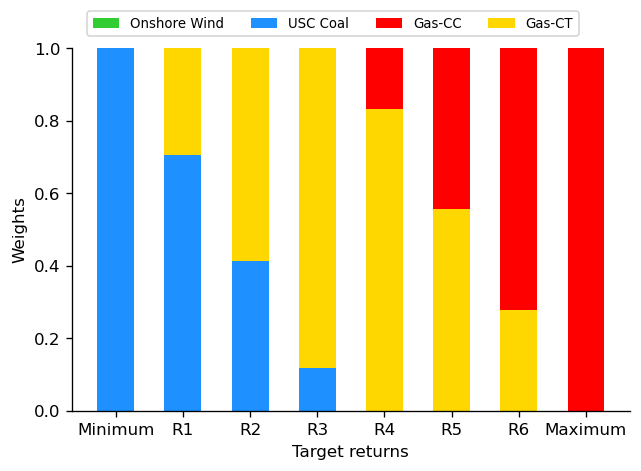

In [542]:
Onshore_Wind = [W[0,0], W[1,0], W[2,0], W[3,0], W[4,0], W[5,0], W[6,0], W[7,0]]
USC_Coal = [W[0,1], W[1,1], W[2,1], W[3,1], W[4,1], W[5,1], W[6,1], W[7,1]]
Gas_CC = [W[0,2], W[1,2], W[2,2], W[3,2], W[4,2], W[5,2], W[6,2], W[7,2]]
Gas_CT = [W[0,3], W[1,3], W[2,3], W[3,3], W[4,3], W[5,3], W[6,3], W[7,3]]
labels = ["Minimum", "R1", "R2", "R3", "R4", "R5", "R6", "Maximum"]
width = 0.55
fig, ax = plt.subplots()
fig.set_facecolor("white")
fig.set_dpi(120)
ax.bar(labels, Onshore_Wind, width, label='Onshore Wind', color="limegreen",bottom=USC_Coal)
ax.bar(labels, USC_Coal, width,
       label='USC Coal', color="dodgerblue")
ax.bar(labels, Gas_CC, width, bottom=Gas_CT,
       label='Gas-CC', color="red")
ax.bar(labels, Gas_CT, width, bottom=USC_Coal,
       label='Gas-CT', color="gold")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Weights')
ax.set_xlabel("Target returns")

ax.legend(loc='best', bbox_to_anchor=(0.5, 0.62, 0.42, 0.5), ncol=4, fontsize=8)

plt.show()

In [498]:
def efficient_frontier(beta, alpha):
    mean_ret = dataset.mean()
    Sigma = dataset.cov()
    num_port = 100
    target_return = np.mean(Value_matrix)
    mean_returns = np.mean(Value_matrix, axis=0)  
    ret_arr = np.zeros(num_port)
    CVaR_arr = np.zeros(num_port)  
    gap = np.amax(np.mean(dataset))/ num_port

    for i in range(num_port):
        port_ret = i*gap
        n_assets = int(Value_matrix.shape[1]) # shape of number of assets
        n_simulations = int(Value_matrix.shape[0]) # shape of number of simulations
        alpha = cp.Variable()
        auxiliary = cp.Variable((n_simulations), nonneg=True)
        weights = cp.Variable((n_assets), nonneg=True)
        objective = cp.Minimize(alpha + cp.sum(auxiliary) * 1/(n_simulations * (1-beta))) 
        constraints = [auxiliary + Value_matrix @ weights + alpha >=0, auxiliary >=0,
                       cp.sum(weights) == 1, weights >=0,
                       mean_returns @ weights == port_ret
                       ]
        min_CVaR = cp.Problem(objective, constraints) 
        ret_arr[i] = port_ret
        CVaR_arr[i] = min_CVaR.solve()*port_ret
        
    return ret_arr, CVaR_arr
%time returns, CVaR = efficient_frontier(0.95, 5)


Wall time: 21.6 s


In [517]:
  def efficient_frontier1(beta, alpha):
    num_port = 10000
    ret_arr = np.zeros(num_port)
    CVaR_arr = np.zeros(num_port)
    weight = np.zeros((num_port,4))
    expected_return = np.zeros(num_port)
    expected_volatility = np.zeros(num_port)
    sharpe_ratio = np.zeros(num_port)
    VaR_p = np.zeros(num_port)
    CVaR_p = np.zeros(num_port)
    CVaR_P = np.zeros(num_port)
    for i in range(num_port):   
        w = np.array(np.random.random(4))
        w = w / np.sum(w)
        weight[i,:] = w
        W, C, G, GCT  =  Wind*weight[i,1], Coal*weight[i,0], CC*(weight[i,2]), CT*weight[i,3]
        Total = G + W + C + GCT
        Covar = np.cov(Total)
        gap = np.mean(Total)/ num_port
        port_ret = i*gap
        expected_return[i] = np.sum( np.mean(Total)* w)
        expected_volatility[i] = np.sqrt(np.dot(w.T,np.dot(Covar, w)))
        sharpe_ratio[i] =  port_ret / expected_volatility[i]
        VaR_p[i] = np.percentile(Total, alpha)
        CVaR_p[i] = np.mean( Total[ Total <= VaR_p[i]])  
        CVaR_P[i] = CVaR_p[i] * port_ret
        ret_arr[i] = port_ret
        sharpe_ratio[i] =   port_ret/ expected_volatility[i]
    return ret_arr, CVaR_P, sharpe_ratio
ret, CVaR1, sharpe = efficient_frontier1(0.95, 5)
maxindex = sharpe.argmax()

                                                          

C:\Users\VALENT~1\AppData\Local\Temp/ipykernel_2704/4200796013.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


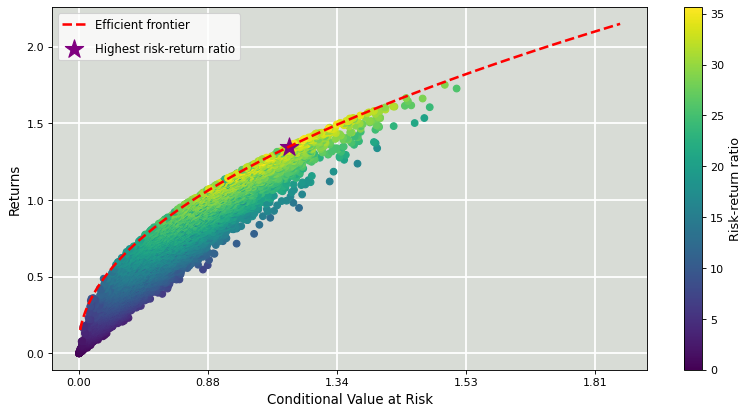

In [519]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,6), dpi=80, facecolor="white")
ax.set_facecolor("#d8dcd6")
plt.scatter(CVaR1, ret, c=sharpe, zorder=2)
X = plt.colorbar()
X.set_label("Risk-return ratio", fontsize=11.5)
plt.scatter(CVaR1[maxindex], ret[maxindex], c="purple", marker="*", s=300, label="Highest risk-return ratio", zorder=2)
plt.plot(-CVaR, returns, '--', linewidth=2.3, color="red", label='Efficient frontier')
plt.ylabel("Returns", fontsize=12)
plt.xlabel("Conditional Value at Risk", fontsize=12, fontweight="normal")
plt.legend(labelspacing=1, fontsize=10.5)
plt.grid(color="white", linewidth=1.6)

plt.show()


NameError: name 'Wind' is not defined

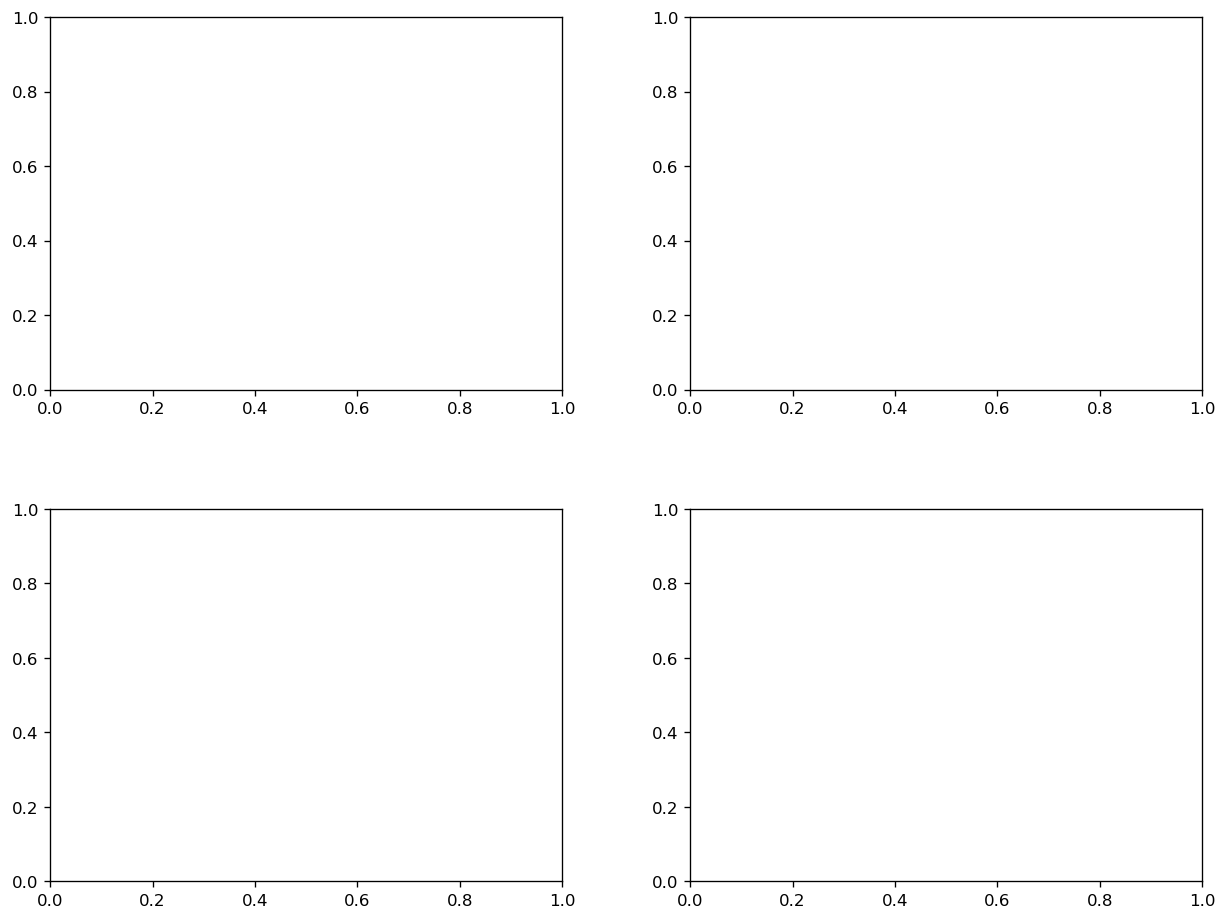

In [3]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,8), dpi=(120), facecolor="white")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.25, 
                    hspace=0.32)
ax1.hist(Wind, bins=40, color="blue", zorder=2)
ax1.set_title('Onshore Wind')
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_xlabel('Returns', fontsize=12)
ax1.grid(True, color= "white", linewidth=1.6)
ax1.set_facecolor("#d8dcd6")
ax2.hist(Coal, bins=40, color="blue", zorder=2)
ax2.set_title('USC Coal')
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_xlabel('Returns', fontsize=12)
ax2.grid(True, color= "white", linewidth=1.6)
ax2.set_facecolor("#d8dcd6")
ax3.hist(CC, bins=40, color="blue", zorder=2)
ax3.set_title('Gas-CC')
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_xlabel('Returns', fontsize=12)
ax3.grid(True, color= "white", linewidth=1.6)
ax3.set_facecolor("#d8dcd6")
ax4.hist(CT, bins=40, color="blue", zorder=2)
ax4.set_title('Gas-CT')
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_xlabel('Returns', fontsize=12)
ax4.grid(True, color= "white", linewidth=1.6)
ax4.set_facecolor("#d8dcd6");


In [474]:
Onshore_Wind = [W[0,0], W[1,0], W[2,0], W[3,0], W[4,0], W[5,0], W[6,0], W[7,0]]
USC_Coal = [W[0,1], W[1,1], W[2,1], W[3,1], W[4,1], W[5,1], W[6,1], W[7,1]]
Gas_CC = [W[0,2], W[1,2], W[2,2], W[3,2], W[4,2], W[5,2], W[6,2], W[7,2]]
Gas_CT = [W[0,3], W[1,3], W[2,3], W[3,3], W[4,3], W[5,3], W[6,3], W[7,3]]

In [475]:
Onshore_Wind, USC_Coal, Gas_CC, Gas_CT

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.8382, 0.56727, 0.29634, 0.02541, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.23177, 0.48753, 0.74329, 0.99905],
 [0.1618, 0.43273, 0.70366, 0.97459, 0.76823, 0.51247, 0.25671, 0.00095])